# Análisis Exploratorio de Datos (EDA) - Tabla: carrito

## Objetivo

Realizar un análisis exploratorio completo de la tabla `carrito` para:
- Explorar la estructura y contenido de los datos
- Detectar valores nulos, duplicados, atípicos e inconsistencias
- Analizar campo numérico (cantidad) y detectar outliers
- Analizar campo temporal (fecha_agregado) y patrones temporales
- Verificar relaciones con usuarios y productos
- Identificar claves primarias y foráneas implícitas
- Analizar campos semi-estructurados
- Proponer acciones de preprocesamiento y corrección de calidad de datos
- Generar reporte de hallazgos y decisiones tomadas


## 1. Configuración Inicial e Importaciones


In [1]:
# Importar bibliotecas necesarias
import sys
import os

try:
    from ...Utils.path_manager import PathManager
except ImportError:
    # Si falla el import relativo 
    current_dir = os.getcwd()  # Directorio actual de trabajo
    if 'Notebooks' in current_dir:
        avance1_dir = os.path.dirname(os.path.dirname(current_dir))
    else:
        # Intentar calcular desde la ubicación relativa
        avance1_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
    
    utils_dir = os.path.join(avance1_dir, 'Utils')
    if utils_dir not in sys.path:
        sys.path.insert(0, utils_dir)
    from path_manager import PathManager

# Configurar sys.path usando PathManager (patrón Singleton)
path_manager = PathManager.get_instance()
path_manager.setup_sys_path()

# Importar DBConnector desde la raíz del proyecto
from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [2]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 2. Exploración de Estructura y Contenido con SQL


### 2.1. Estructura de la Tabla (Schema)


In [3]:
# Consulta SQL para obtener la estructura de la tabla
query_schema = """
SELECT 
    column_name,
    data_type,
    character_maximum_length,
    numeric_precision,
    numeric_scale,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_schema = 'public' 
    AND table_name = 'carrito'
ORDER BY ordinal_position;
"""

df_schema = pd.read_sql(query_schema, engine)

print("=" * 80)
print("ESTRUCTURA DE LA TABLA: carrito")
print("=" * 80)
print(df_schema.to_string(index=False))


ESTRUCTURA DE LA TABLA: carrito
   column_name                   data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                              column_default
    carrito_id                     integer                     None               32.0            0.0          NO nextval('carrito_carrito_id_seq'::regclass)
    usuario_id                     integer                     None               32.0            0.0         YES                                        None
   producto_id                     integer                     None               32.0            0.0         YES                                        None
      cantidad                     integer                     None               32.0            0.0          NO                                        None
fecha_agregado timestamp without time zone                     None                NaN            NaN         YES                                       now()


### 2.2. Restricciones y Claves (Constraints)


In [4]:
# Consulta SQL para obtener restricciones de la tabla
query_constraints = """
SELECT
    tc.constraint_name,
    tc.constraint_type,
    kcu.column_name,
    ccu.table_name AS foreign_table_name,
    ccu.column_name AS foreign_column_name
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
    ON tc.constraint_name = kcu.constraint_name
    AND tc.table_schema = kcu.table_schema
LEFT JOIN information_schema.constraint_column_usage AS ccu
    ON ccu.constraint_name = tc.constraint_name
    AND ccu.table_schema = tc.table_schema
WHERE tc.table_schema = 'public'
    AND tc.table_name = 'carrito'
ORDER BY tc.constraint_type, tc.constraint_name;
"""

df_constraints = pd.read_sql(query_constraints, engine)

print("=" * 80)
print("RESTRICCIONES Y CLAVES DE LA TABLA: carrito")
print("=" * 80)
if not df_constraints.empty:
    print(df_constraints.to_string(index=False))
else:
    print("No se encontraron restricciones explícitas.")

# Consulta adicional para obtener CHECK constraints
query_check = """
SELECT
    conname AS constraint_name,
    pg_get_constraintdef(oid) AS constraint_definition
FROM pg_constraint
WHERE conrelid = 'carrito'::regclass
    AND contype = 'c';
"""

df_check = pd.read_sql(query_check, engine)

if not df_check.empty:
    print("\n" + "=" * 80)
    print("CHECK CONSTRAINTS")
    print("=" * 80)
    print(df_check.to_string(index=False))


RESTRICCIONES Y CLAVES DE LA TABLA: carrito
         constraint_name constraint_type column_name foreign_table_name foreign_column_name
carrito_producto_id_fkey     FOREIGN KEY producto_id          productos         producto_id
 carrito_usuario_id_fkey     FOREIGN KEY  usuario_id           usuarios          usuario_id
            carrito_pkey     PRIMARY KEY  carrito_id            carrito          carrito_id

CHECK CONSTRAINTS
                constraint_name   constraint_definition
check_cantidad_carrito_positiva CHECK ((cantidad >= 0))


### 2.3. Estadísticas Básicas con SQL


In [5]:
# Consultas SQL para estadísticas básicas
query_stats = """
SELECT 
    COUNT(*) as total_registros,
    COUNT(DISTINCT carrito_id) as items_unicos,
    COUNT(DISTINCT usuario_id) as usuarios_distintos,
    COUNT(DISTINCT producto_id) as productos_distintos,
    COUNT(cantidad) as cantidades_no_nulas,
    COUNT(fecha_agregado) as fechas_no_nulas,
    MIN(cantidad) as cantidad_minima,
    MAX(cantidad) as cantidad_maxima,
    AVG(cantidad) as cantidad_promedio,
    SUM(cantidad) as cantidad_total
FROM carrito;
"""

df_stats = pd.read_sql(query_stats, engine)

print("=" * 80)
print("ESTADÍSTICAS BÁSICAS DE LA TABLA: carrito")
print("=" * 80)
print(df_stats.to_string(index=False))

# Top 10 productos más agregados al carrito
query_top_productos = """
SELECT 
    producto_id,
    COUNT(*) as veces_agregado,
    SUM(cantidad) as cantidad_total
FROM carrito
GROUP BY producto_id
ORDER BY veces_agregado DESC
LIMIT 10;
"""

df_top_productos = pd.read_sql(query_top_productos, engine)

print("\n" + "=" * 80)
print("TOP 10 PRODUCTOS MÁS AGREGADOS AL CARRITO")
print("=" * 80)
print(df_top_productos.to_string(index=False))

# Top 10 usuarios con más items en el carrito
query_top_usuarios = """
SELECT 
    usuario_id,
    COUNT(*) as items_en_carrito,
    SUM(cantidad) as cantidad_total
FROM carrito
GROUP BY usuario_id
ORDER BY items_en_carrito DESC
LIMIT 10;
"""

df_top_usuarios = pd.read_sql(query_top_usuarios, engine)

print("\n" + "=" * 80)
print("TOP 10 USUARIOS CON MÁS ITEMS EN EL CARRITO")
print("=" * 80)
print(df_top_usuarios.to_string(index=False))


ESTADÍSTICAS BÁSICAS DE LA TABLA: carrito
 total_registros  items_unicos  usuarios_distintos  productos_distintos  cantidades_no_nulas  fechas_no_nulas  cantidad_minima  cantidad_maxima  cantidad_promedio  cantidad_total
            5000          5000                 996                   36                 5000             5000                1                3             2.0062           10031

TOP 10 PRODUCTOS MÁS AGREGADOS AL CARRITO
 producto_id  veces_agregado  cantidad_total
          27             163             323
          22             158             299
          35             157             325
          17             157             331
          25             155             338
          14             153             287
          23             153             289
           4             152             321
           9             151             313
          34             150             302

TOP 10 USUARIOS CON MÁS ITEMS EN EL CARRITO
 usuario_id  item

In [6]:
# Cargar la tabla completa en un DataFrame
query_carrito = "SELECT * FROM carrito;"
df_carrito = pd.read_sql(query_carrito, engine)

# Convertir fecha_agregado a datetime si no lo está
if 'fecha_agregado' in df_carrito.columns:
    df_carrito['fecha_agregado'] = pd.to_datetime(df_carrito['fecha_agregado'])

print("=" * 80)
print("CARGA DE DATOS COMPLETA")
print("=" * 80)
print(f"Forma del DataFrame: {df_carrito.shape}")
print(f"Columnas: {list(df_carrito.columns)}")
print(f"\nPrimeras 10 filas:")
print(df_carrito.head(10))


CARGA DE DATOS COMPLETA
Forma del DataFrame: (5000, 5)
Columnas: ['carrito_id', 'usuario_id', 'producto_id', 'cantidad', 'fecha_agregado']

Primeras 10 filas:
   carrito_id  usuario_id  producto_id  cantidad      fecha_agregado
0           1         844           22         3 2025-04-29 10:15:10
1           2         901            7         2 2025-05-14 10:15:10
2           3         824           28         1 2025-04-26 10:15:10
3           4          94            5         3 2025-04-20 10:15:10
4           5         228           15         3 2025-05-11 10:15:10
5           6          29           11         1 2025-06-27 10:15:10
6           7         895            7         3 2025-06-09 10:15:10
7           8         561           14         1 2025-04-11 10:15:10
8           9         574           27         3 2025-06-25 10:15:10
9          10         971           27         2 2025-04-25 10:15:10


### 3.1. Información General del DataFrame


In [7]:
# Información detallada del DataFrame
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATAFRAME")
print("=" * 80)
df_carrito.info()
print("\n" + "=" * 80)
print("TIPOS DE DATOS POR COLUMNA")
print("=" * 80)
print(df_carrito.dtypes)
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
print(df_carrito.describe(include='all'))


INFORMACIÓN GENERAL DEL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   carrito_id      5000 non-null   int64         
 1   usuario_id      5000 non-null   int64         
 2   producto_id     5000 non-null   int64         
 3   cantidad        5000 non-null   int64         
 4   fecha_agregado  5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 195.4 KB

TIPOS DE DATOS POR COLUMNA
carrito_id                 int64
usuario_id                 int64
producto_id                int64
cantidad                   int64
fecha_agregado    datetime64[ns]
dtype: object

ESTADÍSTICAS DESCRIPTIVAS
        carrito_id   usuario_id  producto_id     cantidad  \
count  5000.000000  5000.000000  5000.000000  5000.000000   
mean   2500.500000   505.033000    18.414000     2.006200   
min       1.000000  

### 3.2. Detección de Valores Nulos


In [8]:
# Análisis de valores nulos
print("=" * 80)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 80)

nulos_por_columna = df_carrito.isnull().sum()
porcentaje_nulos = (df_carrito.isnull().sum() / len(df_carrito)) * 100

df_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Cantidad_Nulos': nulos_por_columna.values,
    'Porcentaje_Nulos': porcentaje_nulos.values
})

print(df_nulos.to_string(index=False))

# Verificar si hay valores nulos en total
total_nulos = df_carrito.isnull().sum().sum()
print(f"\nTotal de valores nulos en toda la tabla: {total_nulos}")

if total_nulos == 0:
    print("✓ No se encontraron valores nulos en la tabla.")
else:
    print("⚠ ADVERTENCIA: Se encontraron valores nulos que requieren atención.")
    print("\nAnálisis de valores nulos por columna:")
    for col in df_carrito.columns:
        nulos_col = df_carrito[col].isnull().sum()
        if nulos_col > 0:
            print(f"  - {col}: {nulos_col} valores nulos ({nulos_col/len(df_carrito)*100:.1f}%)")
            # Verificar si el campo es obligatorio
            if col in ['usuario_id', 'producto_id', 'cantidad']:
                print(f"    ⚠ CRÍTICO: Campo obligatorio con valores nulos")


ANÁLISIS DE VALORES NULOS
       Columna  Cantidad_Nulos  Porcentaje_Nulos
    carrito_id               0               0.0
    usuario_id               0               0.0
   producto_id               0               0.0
      cantidad               0               0.0
fecha_agregado               0               0.0

Total de valores nulos en toda la tabla: 0
✓ No se encontraron valores nulos en la tabla.


### 3.3. Detección de Duplicados


In [9]:
# Análisis de duplicados
print("=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados completos (todas las columnas)
duplicados_completos = df_carrito.duplicated().sum()
print(f"Registros completamente duplicados: {duplicados_completos}")

# Duplicados por carrito_id (clave primaria)
duplicados_carrito_id = df_carrito['carrito_id'].duplicated().sum()
print(f"Duplicados en carrito_id (PK): {duplicados_carrito_id}")

# Duplicados por combinación usuario_id + producto_id (puede ser válido si un usuario agrega el mismo producto múltiples veces)
duplicados_usuario_producto = df_carrito.duplicated(subset=['usuario_id', 'producto_id']).sum()
print(f"Duplicados en combinación (usuario_id, producto_id): {duplicados_usuario_producto}")

# Mostrar duplicados si existen
if duplicados_completos > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron registros completamente duplicados:")
    duplicados = df_carrito[df_carrito.duplicated(keep=False)]
    print(duplicados.sort_values('carrito_id'))

if duplicados_usuario_producto > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron múltiples registros para la misma combinación (usuario_id, producto_id):")
    duplicados_up = df_carrito[df_carrito.duplicated(subset=['usuario_id', 'producto_id'], keep=False)]
    print(f"Total de registros duplicados: {len(duplicados_up)}")
    print("\nNota: Esto puede ser válido si un usuario agrega el mismo producto en diferentes momentos,")
    print("pero podría indicar un problema de diseño si se espera una única entrada por usuario-producto.")
    print(duplicados_up.sort_values(['usuario_id', 'producto_id']).head(20))

if duplicados_completos == 0 and duplicados_carrito_id == 0:
    print("\n✓ No se encontraron duplicados completos en la tabla.")


ANÁLISIS DE DUPLICADOS
Registros completamente duplicados: 0
Duplicados en carrito_id (PK): 0
Duplicados en combinación (usuario_id, producto_id): 336

⚠ ADVERTENCIA: Se encontraron múltiples registros para la misma combinación (usuario_id, producto_id):
Total de registros duplicados: 666

Nota: Esto puede ser válido si un usuario agrega el mismo producto en diferentes momentos,
pero podría indicar un problema de diseño si se espera una única entrada por usuario-producto.
      carrito_id  usuario_id  producto_id  cantidad      fecha_agregado
2409        2410           2           20         2 2025-05-12 10:15:10
3758        3759           2           20         3 2025-04-19 10:15:10
429          430           2           23         2 2025-05-23 10:15:10
2877        2878           2           23         2 2025-04-14 10:15:10
1573        1574           5           24         3 2025-05-17 10:15:10
3790        3791           5           24         1 2025-06-30 10:15:10
1818        1819   

### 3.4. Análisis de Campo Numérico (cantidad)


In [10]:
# Análisis del campo cantidad
print("=" * 80)
print("ANÁLISIS DEL CAMPO: cantidad")
print("=" * 80)

cantidad = df_carrito['cantidad']

print(f"\nEstadísticas Descriptivas:")
print(f"  - Mínimo: {cantidad.min()}")
print(f"  - Máximo: {cantidad.max()}")
print(f"  - Media: {cantidad.mean():.2f}")
print(f"  - Mediana: {cantidad.median():.2f}")
print(f"  - Desviación estándar: {cantidad.std():.2f}")
print(f"  - Q1 (25%): {cantidad.quantile(0.25)}")
print(f"  - Q3 (75%): {cantidad.quantile(0.75)}")
print(f"  - IQR: {cantidad.quantile(0.75) - cantidad.quantile(0.25):.2f}")

# Valores negativos
valores_negativos = (cantidad < 0).sum()
print(f"\nValores negativos: {valores_negativos}")
if valores_negativos > 0:
    print("⚠ ADVERTENCIA: Se encontraron valores negativos que violan el CHECK constraint")
    print(df_carrito[cantidad < 0][['carrito_id', 'usuario_id', 'producto_id', 'cantidad']])

# Valores cero
valores_cero = (cantidad == 0).sum()
print(f"\nValores cero: {valores_cero}")
if valores_cero > 0:
    print("⚠ ADVERTENCIA: Se encontraron valores cero (productos con cantidad 0 en el carrito)")
    print(df_carrito[cantidad == 0][['carrito_id', 'usuario_id', 'producto_id', 'cantidad']].head(10))

# Detección de outliers usando IQR
Q1 = cantidad.quantile(0.25)
Q3 = cantidad.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = cantidad[(cantidad < limite_inferior) | (cantidad > limite_superior)]
print(f"\nOutliers detectados (método IQR): {len(outliers)}")
print(f"  - Límite inferior: {max(0, limite_inferior):.2f} (ajustado a 0 por ser cantidad)")
print(f"  - Límite superior: {limite_superior:.2f}")

if len(outliers) > 0:
    print(f"\nDistribución de outliers:")
    print(outliers.value_counts().head(10))
    print(f"\nEjemplos de registros con outliers:")
    print(df_carrito[cantidad.isin(outliers)][['carrito_id', 'usuario_id', 'producto_id', 'cantidad']].head(10))

# Distribución de cantidades
print(f"\nDistribución de cantidades:")
print(cantidad.value_counts().head(20))


ANÁLISIS DEL CAMPO: cantidad

Estadísticas Descriptivas:
  - Mínimo: 1
  - Máximo: 3
  - Media: 2.01
  - Mediana: 2.00
  - Desviación estándar: 0.81
  - Q1 (25%): 1.0
  - Q3 (75%): 3.0
  - IQR: 2.00

Valores negativos: 0

Valores cero: 0

Outliers detectados (método IQR): 0
  - Límite inferior: 0.00 (ajustado a 0 por ser cantidad)
  - Límite superior: 6.00

Distribución de cantidades:
cantidad
2    1691
3    1670
1    1639
Name: count, dtype: int64


### 3.5. Análisis de Campo Temporal (fecha_agregado)


In [11]:
# Análisis del campo fecha_agregado
print("=" * 80)
print("ANÁLISIS DEL CAMPO: fecha_agregado")
print("=" * 80)

fecha_agregado = df_carrito['fecha_agregado'].dropna()

if len(fecha_agregado) > 0:
    print(f"\nEstadísticas Temporales:")
    print(f"  - Fecha mínima: {fecha_agregado.min()}")
    print(f"  - Fecha máxima: {fecha_agregado.max()}")
    print(f"  - Rango temporal: {(fecha_agregado.max() - fecha_agregado.min()).days} días")
    
    # Fechas futuras (posibles errores)
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = fecha_agregado[fecha_agregado > fecha_actual]
    print(f"\nFechas futuras (posibles errores): {len(fechas_futuras)}")
    if len(fechas_futuras) > 0:
        print("⚠ ADVERTENCIA: Se encontraron fechas futuras")
        print(df_carrito[df_carrito['fecha_agregado'] > fecha_actual][['carrito_id', 'usuario_id', 'producto_id', 'fecha_agregado']].head(10))
    
    # Fechas muy antiguas (posibles errores, más de 10 años)
    fecha_limite_antigua = fecha_actual - pd.Timedelta(days=3650)
    fechas_antiguas = fecha_agregado[fecha_agregado < fecha_limite_antigua]
    print(f"\nFechas muy antiguas (> 10 años): {len(fechas_antiguas)}")
    if len(fechas_antiguas) > 0:
        print("⚠ ADVERTENCIA: Se encontraron fechas muy antiguas")
        print(df_carrito[df_carrito['fecha_agregado'] < fecha_limite_antigua][['carrito_id', 'usuario_id', 'producto_id', 'fecha_agregado']].head(10))
    
    # Distribución por año
    print(f"\nDistribución por año:")
    distribucion_anio = fecha_agregado.dt.year.value_counts().sort_index()
    print(distribucion_anio)
    
    # Distribución por mes (del año más reciente)
    anio_mas_reciente = fecha_agregado.dt.year.max()
    print(f"\nDistribución por mes (año {anio_mas_reciente}):")
    distribucion_mes = fecha_agregado[fecha_agregado.dt.year == anio_mas_reciente].dt.month.value_counts().sort_index()
    print(distribucion_mes)
    
    # Distribución por día de la semana
    print(f"\nDistribución por día de la semana:")
    distribucion_dia = fecha_agregado.dt.day_name().value_counts()
    print(distribucion_dia)
else:
    print("⚠ No hay fechas para analizar (todos los valores son nulos)")


ANÁLISIS DEL CAMPO: fecha_agregado

Estadísticas Temporales:
  - Fecha mínima: 2025-04-01 10:15:10
  - Fecha máxima: 2025-06-30 10:15:10
  - Rango temporal: 90 días

Fechas futuras (posibles errores): 0

Fechas muy antiguas (> 10 años): 0

Distribución por año:
fecha_agregado
2025    5000
Name: count, dtype: int64

Distribución por mes (año 2025):
fecha_agregado
4    1560
5    1756
6    1684
Name: count, dtype: int64

Distribución por día de la semana:
fecha_agregado
Monday       744
Saturday     743
Wednesday    732
Sunday       709
Friday       702
Tuesday      701
Thursday     669
Name: count, dtype: int64


### 3.6. Análisis de Relaciones con Usuarios y Productos


In [12]:
# Análisis de relaciones
print("=" * 80)
print("ANÁLISIS DE RELACIONES CON USUARIOS Y PRODUCTOS")
print("=" * 80)

# Verificar valores nulos en foreign keys
usuario_id_nulos = df_carrito['usuario_id'].isnull().sum()
producto_id_nulos = df_carrito['producto_id'].isnull().sum()

print(f"\nValores nulos en foreign keys:")
print(f"  - usuario_id nulos: {usuario_id_nulos}")
print(f"  - producto_id nulos: {producto_id_nulos}")

# Distribución por usuario
print(f"\nDistribución de items por usuario:")
distribucion_usuario = df_carrito['usuario_id'].value_counts()
print(f"  - Usuarios distintos con items en carrito: {distribucion_usuario.nunique()}")
print(f"  - Promedio de items por usuario: {distribucion_usuario.mean():.2f}")
print(f"  - Máximo de items por usuario: {distribucion_usuario.max()}")
print(f"  - Mínimo de items por usuario: {distribucion_usuario.min()}")

# Distribución por producto
print(f"\nDistribución de items por producto:")
distribucion_producto = df_carrito['producto_id'].value_counts()
print(f"  - Productos distintos en carritos: {distribucion_producto.nunique()}")
print(f"  - Promedio de veces que un producto aparece: {distribucion_producto.mean():.2f}")
print(f"  - Máximo de veces que un producto aparece: {distribucion_producto.max()}")
print(f"  - Mínimo de veces que un producto aparece: {distribucion_producto.min()}")

# Verificar referencias huérfanas (usuario_id que no existe en usuarios)
query_orphan_usuario = """
SELECT COUNT(*) as huérfanas
FROM carrito c
LEFT JOIN usuarios u ON c.usuario_id = u.usuario_id
WHERE c.usuario_id IS NOT NULL AND u.usuario_id IS NULL;
"""

df_orphan_usuario = pd.read_sql(query_orphan_usuario, engine)
huérfanas_usuario = df_orphan_usuario['huérfanas'].iloc[0]

if huérfanas_usuario > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas_usuario} referencias huérfanas (usuario_id que no existe en usuarios)")
    query_orphan_usuario_detalle = """
    SELECT c.carrito_id, c.usuario_id, c.producto_id, c.cantidad
    FROM carrito c
    LEFT JOIN usuarios u ON c.usuario_id = u.usuario_id
    WHERE c.usuario_id IS NOT NULL AND u.usuario_id IS NULL
    LIMIT 10;
    """
    df_orphan_usuario_detalle = pd.read_sql(query_orphan_usuario_detalle, engine)
    print(df_orphan_usuario_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas de usuarios.")

# Verificar referencias huérfanas (producto_id que no existe en productos)
query_orphan_producto = """
SELECT COUNT(*) as huérfanas
FROM carrito c
LEFT JOIN productos p ON c.producto_id = p.producto_id
WHERE c.producto_id IS NOT NULL AND p.producto_id IS NULL;
"""

df_orphan_producto = pd.read_sql(query_orphan_producto, engine)
huérfanas_producto = df_orphan_producto['huérfanas'].iloc[0]

if huérfanas_producto > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas_producto} referencias huérfanas (producto_id que no existe en productos)")
    query_orphan_producto_detalle = """
    SELECT c.carrito_id, c.usuario_id, c.producto_id, c.cantidad
    FROM carrito c
    LEFT JOIN productos p ON c.producto_id = p.producto_id
    WHERE c.producto_id IS NOT NULL AND p.producto_id IS NULL
    LIMIT 10;
    """
    df_orphan_producto_detalle = pd.read_sql(query_orphan_producto_detalle, engine)
    print(df_orphan_producto_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas de productos.")


ANÁLISIS DE RELACIONES CON USUARIOS Y PRODUCTOS

Valores nulos en foreign keys:
  - usuario_id nulos: 0
  - producto_id nulos: 0

Distribución de items por usuario:
  - Usuarios distintos con items en carrito: 13
  - Promedio de items por usuario: 5.02
  - Máximo de items por usuario: 14
  - Mínimo de items por usuario: 1

Distribución de items por producto:
  - Productos distintos en carritos: 27
  - Promedio de veces que un producto aparece: 138.89
  - Máximo de veces que un producto aparece: 163
  - Mínimo de veces que un producto aparece: 113

✓ No se encontraron referencias huérfanas de usuarios.

✓ No se encontraron referencias huérfanas de productos.


### 3.7. Detección de Valores Atípicos y Anomalías


In [13]:
# Detección de valores atípicos y anomalías
print("=" * 80)
print("DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS")
print("=" * 80)

anomalias = []

# 1. Items sin usuario
items_sin_usuario = df_carrito[df_carrito['usuario_id'].isnull()]
if len(items_sin_usuario) > 0:
    print(f"⚠ Items sin usuario asignado: {len(items_sin_usuario)}")
    anomalias.append(('Sin usuario', len(items_sin_usuario)))
    print(items_sin_usuario[['carrito_id', 'producto_id', 'cantidad']])

# 2. Items sin producto
items_sin_producto = df_carrito[df_carrito['producto_id'].isnull()]
if len(items_sin_producto) > 0:
    print(f"\n⚠ Items sin producto asignado: {len(items_sin_producto)}")
    anomalias.append(('Sin producto', len(items_sin_producto)))
    print(items_sin_producto[['carrito_id', 'usuario_id', 'cantidad']])

# 3. Cantidades negativas
cantidades_negativas = df_carrito[df_carrito['cantidad'] < 0]
if len(cantidades_negativas) > 0:
    print(f"\n⚠ Cantidades negativas: {len(cantidades_negativas)}")
    anomalias.append(('Cantidades negativas', len(cantidades_negativas)))
    print(cantidades_negativas[['carrito_id', 'usuario_id', 'producto_id', 'cantidad']])

# 4. Cantidades cero
cantidades_cero = df_carrito[df_carrito['cantidad'] == 0]
if len(cantidades_cero) > 0:
    print(f"\n⚠ Cantidades cero: {len(cantidades_cero)}")
    anomalias.append(('Cantidades cero', len(cantidades_cero)))
    print(cantidades_cero[['carrito_id', 'usuario_id', 'producto_id', 'cantidad']].head(10))

# 5. Cantidades muy altas (outliers)
Q1 = df_carrito['cantidad'].quantile(0.25)
Q3 = df_carrito['cantidad'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
cantidades_altas = df_carrito[df_carrito['cantidad'] > limite_superior]
if len(cantidades_altas) > 0:
    print(f"\n⚠ Cantidades muy altas (outliers): {len(cantidades_altas)}")
    anomalias.append(('Cantidades muy altas', len(cantidades_altas)))
    print(f"Límite superior (IQR): {limite_superior:.2f}")
    print(cantidades_altas[['carrito_id', 'usuario_id', 'producto_id', 'cantidad']].head(10))

# 6. Fechas futuras
if 'fecha_agregado' in df_carrito.columns:
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = df_carrito[df_carrito['fecha_agregado'] > fecha_actual]
    if len(fechas_futuras) > 0:
        print(f"\n⚠ Fechas futuras: {len(fechas_futuras)}")
        anomalias.append(('Fechas futuras', len(fechas_futuras)))
        print(fechas_futuras[['carrito_id', 'usuario_id', 'producto_id', 'fecha_agregado']].head(10))

# 7. Items completamente duplicados
duplicados_completos = df_carrito.duplicated().sum()
if duplicados_completos > 0:
    print(f"\n⚠ Items completamente duplicados: {duplicados_completos}")
    anomalias.append(('Duplicados completos', duplicados_completos))

# Resumen de anomalías
if len(anomalias) == 0:
    print("\n✓ No se detectaron anomalías significativas.")
else:
    print("\n" + "=" * 80)
    print("RESUMEN DE ANOMALÍAS DETECTADAS")
    print("=" * 80)
    df_anomalias = pd.DataFrame(anomalias, columns=['Tipo de Anomalía', 'Cantidad'])
    print(df_anomalias.to_string(index=False))


DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS

✓ No se detectaron anomalías significativas.


## 4. Identificación de Claves Primarias y Foráneas


In [14]:
# Identificación de claves primarias y foráneas
print("=" * 80)
print("IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS")
print("=" * 80)

# Clave primaria explícita
print("\n1. CLAVE PRIMARIA:")
print("   - carrito_id: PRIMARY KEY, AUTO_INCREMENT")
print(f"   - Rango de valores: {df_carrito['carrito_id'].min()} a {df_carrito['carrito_id'].max()}")
print(f"   - Valores únicos: {df_carrito['carrito_id'].nunique()}")
print(f"   - Total de registros: {len(df_carrito)}")
print(f"   - ¿Sin duplicados?: {df_carrito['carrito_id'].nunique() == len(df_carrito)}")

# Verificar si hay gaps en la secuencia
ids_ordenados = sorted(df_carrito['carrito_id'].tolist())
gaps = []
for i in range(len(ids_ordenados) - 1):
    if ids_ordenados[i+1] - ids_ordenados[i] > 1:
        gaps.append((ids_ordenados[i], ids_ordenados[i+1]))
if gaps:
    print(f"   ⚠ Se encontraron gaps en la secuencia: {len(gaps)} gaps")
    if len(gaps) <= 10:
        print(f"   Primeros gaps: {gaps[:10]}")
else:
    print(f"   ✓ La secuencia de IDs es continua")

# Claves foráneas
print("\n2. CLAVES FORÁNEAS:")
print("   - usuario_id: FOREIGN KEY → usuarios.usuario_id")
usuario_id_nulos = df_carrito['usuario_id'].isnull().sum()
print(f"     - Valores nulos: {usuario_id_nulos}")
print(f"     - Usuarios distintos: {df_carrito['usuario_id'].nunique()}")

print("   - producto_id: FOREIGN KEY → productos.producto_id")
producto_id_nulos = df_carrito['producto_id'].isnull().sum()
print(f"     - Valores nulos: {producto_id_nulos}")
print(f"     - Productos distintos: {df_carrito['producto_id'].nunique()}")

print("\n3. RELACIONES:")
print("   - Esta tabla es referenciada por: Ninguna (tabla de detalle)")
print("   - Relaciones salientes:")
print("     - usuario_id → usuarios.usuario_id (relación N:1)")
print("     - producto_id → productos.producto_id (relación N:1)")


IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS

1. CLAVE PRIMARIA:
   - carrito_id: PRIMARY KEY, AUTO_INCREMENT
   - Rango de valores: 1 a 5000
   - Valores únicos: 5000
   - Total de registros: 5000
   - ¿Sin duplicados?: True
   ✓ La secuencia de IDs es continua

2. CLAVES FORÁNEAS:
   - usuario_id: FOREIGN KEY → usuarios.usuario_id
     - Valores nulos: 0
     - Usuarios distintos: 996
   - producto_id: FOREIGN KEY → productos.producto_id
     - Valores nulos: 0
     - Productos distintos: 36

3. RELACIONES:
   - Esta tabla es referenciada por: Ninguna (tabla de detalle)
   - Relaciones salientes:
     - usuario_id → usuarios.usuario_id (relación N:1)
     - producto_id → productos.producto_id (relación N:1)


## 5. Análisis de Campos Semi-Estructurados


In [15]:
# Análisis de campos semi-estructurados
print("=" * 80)
print("ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS")
print("=" * 80)

# Verificar si hay campos JSON, listas o concatenaciones delimitadas
campos_analizar = ['carrito_id', 'usuario_id', 'producto_id', 'cantidad', 'fecha_agregado']

print("\nBúsqueda de campos que puedan contener datos semi-estructurados:\n")

# 1. Buscar campos que contengan JSON
print("1. Campos con formato JSON:")
json_encontrado = False
for campo in campos_analizar:
    if df_carrito[campo].dtype == 'object':  # Solo campos de texto
        valores_no_nulos = df_carrito[campo].dropna()
        if len(valores_no_nulos) > 0:
            json_pattern = r'\{.*\}|\[.*\]'
            tiene_json = valores_no_nulos.astype(str).str.contains(json_pattern, na=False, regex=True).sum()
            if tiene_json > 0:
                print(f"   ⚠ {campo}: {tiene_json} registros con posible formato JSON")
                json_encontrado = True
if not json_encontrado:
    print("   ✓ No se encontraron campos con formato JSON")

# 2. Buscar campos con delimitadores comunes (listas)
print("\n2. Campos con delimitadores (listas):")
delimitadores = [',', ';', '|', '||']
delimitadores_encontrados = False
for campo in campos_analizar:
    if df_carrito[campo].dtype == 'object':  # Solo campos de texto
        valores_no_nulos = df_carrito[campo].dropna()
        if len(valores_no_nulos) > 0:
            for delim in delimitadores:
                tiene_delim = valores_no_nulos.astype(str).str.contains(delim, na=False, regex=False).sum()
                if tiene_delim > 0:
                    print(f"   ⚠ {campo}: {tiene_delim} registros con delimitador '{delim}'")
                    delimitadores_encontrados = True
if not delimitadores_encontrados:
    print("   ✓ No se encontraron campos con delimitadores estructurados")

print("\n" + "=" * 80)
print("CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:")
print("=" * 80)
print("La tabla 'carrito' contiene únicamente campos estructurados:")
print("- Identificadores numéricos (carrito_id, usuario_id, producto_id)")
print("- Campo numérico (cantidad)")
print("- Campo temporal (fecha_agregado)")
print("No se encontraron campos JSON, listas o concatenaciones que requieran transformación.")


ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS

Búsqueda de campos que puedan contener datos semi-estructurados:

1. Campos con formato JSON:
   ✓ No se encontraron campos con formato JSON

2. Campos con delimitadores (listas):
   ✓ No se encontraron campos con delimitadores estructurados

CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:
La tabla 'carrito' contiene únicamente campos estructurados:
- Identificadores numéricos (carrito_id, usuario_id, producto_id)
- Campo numérico (cantidad)
- Campo temporal (fecha_agregado)
No se encontraron campos JSON, listas o concatenaciones que requieran transformación.


## 6. Visualizaciones


GENERANDO VISUALIZACIONES


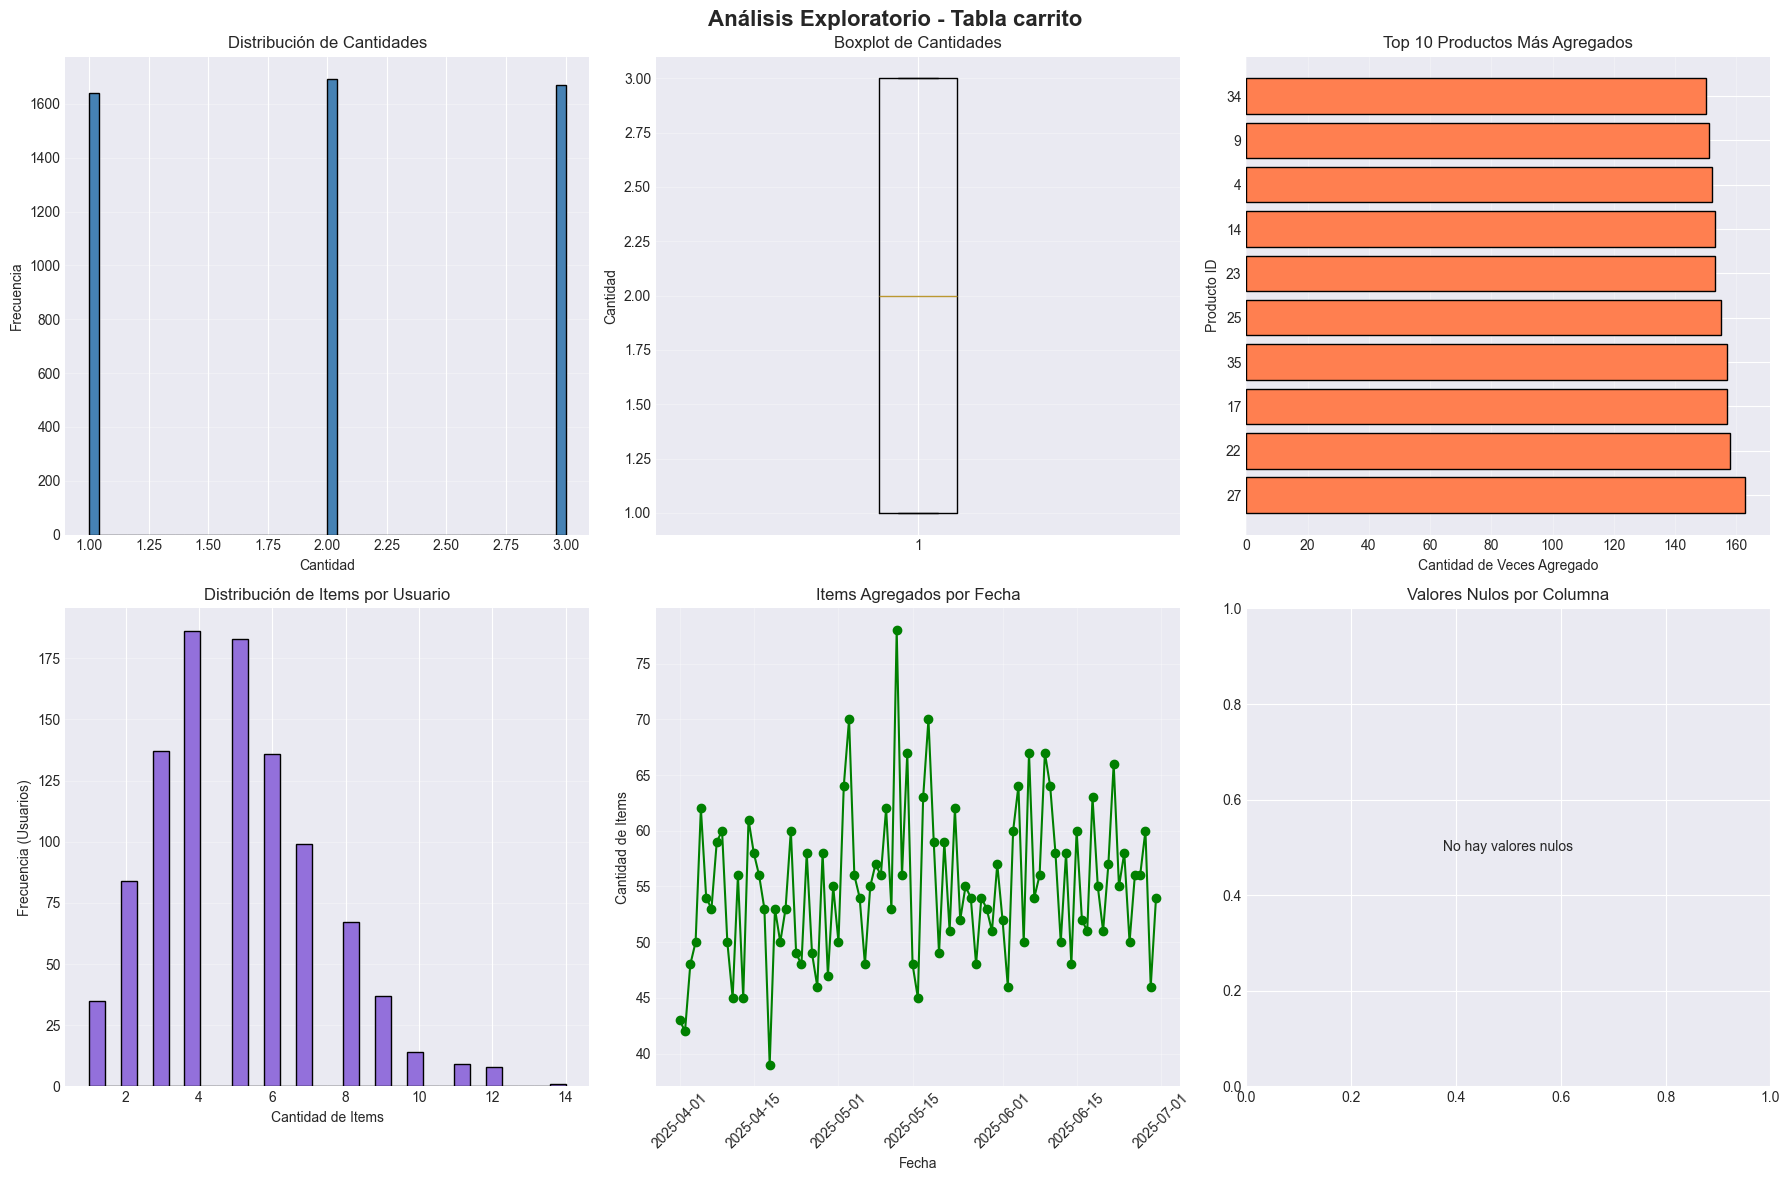

✓ Visualizaciones generadas correctamente


In [16]:
# Visualizaciones
print("=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

# Configurar el tamaño de las figuras
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio - Tabla carrito', fontsize=16, fontweight='bold')

# 1. Distribución de cantidades
ax1 = axes[0, 0]
ax1.hist(df_carrito['cantidad'], bins=50, color='steelblue', edgecolor='black')
ax1.set_title('Distribución de Cantidades')
ax1.set_xlabel('Cantidad')
ax1.set_ylabel('Frecuencia')
ax1.grid(axis='y', alpha=0.3)

# 2. Boxplot de cantidades
ax2 = axes[0, 1]
ax2.boxplot(df_carrito['cantidad'], vert=True)
ax2.set_title('Boxplot de Cantidades')
ax2.set_ylabel('Cantidad')
ax2.grid(axis='y', alpha=0.3)

# 3. Top 10 productos más agregados
ax3 = axes[0, 2]
top_productos = df_carrito['producto_id'].value_counts().head(10)
ax3.barh(range(len(top_productos)), top_productos.values, color='coral', edgecolor='black')
ax3.set_title('Top 10 Productos Más Agregados')
ax3.set_xlabel('Cantidad de Veces Agregado')
ax3.set_ylabel('Producto ID')
ax3.set_yticks(range(len(top_productos)))
ax3.set_yticklabels(top_productos.index)
ax3.grid(axis='x', alpha=0.3)

# 4. Distribución de items por usuario
ax4 = axes[1, 0]
distribucion_usuario = df_carrito['usuario_id'].value_counts()
ax4.hist(distribucion_usuario.values, bins=30, color='mediumpurple', edgecolor='black')
ax4.set_title('Distribución de Items por Usuario')
ax4.set_xlabel('Cantidad de Items')
ax4.set_ylabel('Frecuencia (Usuarios)')
ax4.grid(axis='y', alpha=0.3)

# 5. Distribución temporal (si hay fechas)
ax5 = axes[1, 1]
if 'fecha_agregado' in df_carrito.columns and df_carrito['fecha_agregado'].notna().sum() > 0:
    fechas_no_nulas = df_carrito['fecha_agregado'].dropna()
    if len(fechas_no_nulas) > 0:
        fechas_no_nulas.groupby(fechas_no_nulas.dt.date).size().plot(kind='line', ax=ax5, color='green', marker='o')
        ax5.set_title('Items Agregados por Fecha')
        ax5.set_xlabel('Fecha')
        ax5.set_ylabel('Cantidad de Items')
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(alpha=0.3)
    else:
        ax5.text(0.5, 0.5, 'No hay fechas para mostrar', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Items Agregados por Fecha')
else:
    ax5.text(0.5, 0.5, 'No hay fechas para mostrar', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Items Agregados por Fecha')

# 6. Valores nulos por columna
ax6 = axes[1, 2]
nulos_por_columna = df_carrito.isnull().sum()
nulos_por_columna = nulos_por_columna[nulos_por_columna > 0]
if len(nulos_por_columna) > 0:
    ax6.barh(range(len(nulos_por_columna)), nulos_por_columna.values, color='red', edgecolor='black')
    ax6.set_title('Valores Nulos por Columna')
    ax6.set_xlabel('Cantidad de Nulos')
    ax6.set_ylabel('Columna')
    ax6.set_yticks(range(len(nulos_por_columna)))
    ax6.set_yticklabels(nulos_por_columna.index)
    ax6.grid(axis='x', alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No hay valores nulos', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Valores Nulos por Columna')

plt.tight_layout()
plt.show()

print("✓ Visualizaciones generadas correctamente")


### 7.1. Principales Insights y Problemas Encontrados


In [17]:
# Generar reporte de hallazgos
print("=" * 80)
print("REPORTE DE HALLAZGOS - TABLA: carrito")
print("=" * 80)

# Recalcular variables necesarias para el reporte
total_nulos = df_carrito.isnull().sum().sum()

# Recalcular anomalías si no están definidas
if 'anomalias' not in locals():
    anomalias = []
    items_sin_usuario = df_carrito[df_carrito['usuario_id'].isnull()]
    if len(items_sin_usuario) > 0:
        anomalias.append(('Sin usuario', len(items_sin_usuario)))

hallazgos = []

# 1. Calidad general de datos
print("\n1. CALIDAD GENERAL DE DATOS:")
print("   ✓ Total de registros:", len(df_carrito))
print("   ✓ Valores nulos:", total_nulos)
print("   ✓ Duplicados completos:", df_carrito.duplicated().sum())
print("   ✓ Integridad de clave primaria:", "OK" if df_carrito['carrito_id'].nunique() == len(df_carrito) else "ERROR")

hallazgos.append({
    'Categoría': 'Calidad General',
    'Hallazgo': f'Tabla con {len(df_carrito)} registros. Integridad de clave primaria correcta.',
    'Severidad': 'Baja',
    'Estado': 'OK'
})

# 2. Problemas detectados
print("\n2. PROBLEMAS DETECTADOS:")

problemas = []

# Items sin usuario
usuario_id_nulos = df_carrito['usuario_id'].isnull().sum()
if usuario_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Items sin usuario asignado: {usuario_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar usuario a items sin usuario o eliminar si son inválidos'
    })

# Items sin producto
producto_id_nulos = df_carrito['producto_id'].isnull().sum()
if producto_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Items sin producto asignado: {producto_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar producto a items sin producto o eliminar si son inválidos'
    })

# Cantidades negativas
cantidades_negativas = df_carrito[df_carrito['cantidad'] < 0]
if len(cantidades_negativas) > 0:
    problemas.append({
        'Categoría': 'Validación de Constraint',
        'Problema': f'Cantidades negativas: {len(cantidades_negativas)}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Corregir cantidades negativas (violan CHECK constraint)'
    })

# Cantidades cero
cantidades_cero = df_carrito[df_carrito['cantidad'] == 0]
if len(cantidades_cero) > 0:
    problemas.append({
        'Categoría': 'Lógica de Negocio',
        'Problema': f'Cantidades cero: {len(cantidades_cero)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar items con cantidad cero (posible limpieza de carrito)'
    })

# Cantidades muy altas (outliers)
Q1 = df_carrito['cantidad'].quantile(0.25)
Q3 = df_carrito['cantidad'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
cantidades_altas = df_carrito[df_carrito['cantidad'] > limite_superior]
if len(cantidades_altas) > 0:
    problemas.append({
        'Categoría': 'Outliers',
        'Problema': f'Cantidades muy altas (outliers): {len(cantidades_altas)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar cantidades muy altas para validar si son correctas'
    })

# Fechas futuras
if 'fecha_agregado' in df_carrito.columns:
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = df_carrito[df_carrito['fecha_agregado'] > fecha_actual]
    if len(fechas_futuras) > 0:
        problemas.append({
            'Categoría': 'Validación Temporal',
            'Problema': f'Fechas futuras: {len(fechas_futuras)}',
            'Severidad': 'Media',
            'Acción Requerida': 'Corregir fechas futuras'
        })

# Anomalías detectadas
if len(anomalias) > 0:
    for tipo, cantidad in anomalias:
        if tipo not in ['Sin usuario', 'Sin producto']:  # Ya incluidos arriba
            problemas.append({
                'Categoría': 'Anomalías',
                'Problema': f'{tipo}: {cantidad}',
                'Severidad': 'Media',
                'Acción Requerida': 'Revisar y corregir según corresponda'
            })

if len(problemas) == 0:
    print("   ✓ No se detectaron problemas significativos")
    hallazgos.append({
        'Categoría': 'Problemas',
        'Hallazgo': 'No se encontraron problemas críticos',
        'Severidad': 'N/A',
        'Estado': 'OK'
    })
else:
    df_problemas = pd.DataFrame(problemas)
    print(df_problemas.to_string(index=False))
    for p in problemas:
        hallazgos.append({
            'Categoría': p['Categoría'],
            'Hallazgo': p['Problema'],
            'Severidad': p['Severidad'],
            'Estado': 'PENDIENTE'
        })

# 3. Atributos principales y variables relevantes
print("\n3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:")

atributos = [
    {
        'Atributo': 'carrito_id',
        'Tipo': 'Clave Primaria',
        'Relevancia Negocio': 'Alta - Identificador único del item en el carrito',
        'Uso': 'Relaciones y trazabilidad de items en carrito'
    },
    {
        'Atributo': 'usuario_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica al usuario propietario del carrito',
        'Uso': 'Asociación de items con usuarios, gestión de carritos'
    },
    {
        'Atributo': 'producto_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica el producto en el carrito',
        'Uso': 'Asociación de items con productos, análisis de productos más agregados'
    },
    {
        'Atributo': 'cantidad',
        'Tipo': 'Campo Numérico',
        'Relevancia Negocio': 'Alta - Cantidad del producto en el carrito',
        'Uso': 'Cálculo de totales, análisis de comportamiento de compra'
    },
    {
        'Atributo': 'fecha_agregado',
        'Tipo': 'Campo Temporal',
        'Relevancia Negocio': 'Media - Fecha en que se agregó el producto',
        'Uso': 'Análisis temporal, identificación de carritos abandonados'
    }
]

df_atributos = pd.DataFrame(atributos)
print(df_atributos.to_string(index=False))

# 4. Relaciones detectadas
print("\n4. RELACIONES DETECTADAS:")
print("   La tabla 'carrito' tiene:")
print("   - usuario_id → usuarios.usuario_id (relación N:1)")
print("   - producto_id → productos.producto_id (relación N:1)")
print("   - Es una tabla de detalle que no es referenciada por otras tablas")

print("\n" + "=" * 80)
print("RESUMEN DE HALLAZGOS")
print("=" * 80)
df_hallazgos = pd.DataFrame(hallazgos)
print(df_hallazgos.to_string(index=False))


REPORTE DE HALLAZGOS - TABLA: carrito

1. CALIDAD GENERAL DE DATOS:
   ✓ Total de registros: 5000
   ✓ Valores nulos: 0
   ✓ Duplicados completos: 0
   ✓ Integridad de clave primaria: OK

2. PROBLEMAS DETECTADOS:
   ✓ No se detectaron problemas significativos

3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:
      Atributo           Tipo                                   Relevancia Negocio                                                                    Uso
    carrito_id Clave Primaria    Alta - Identificador único del item en el carrito                          Relaciones y trazabilidad de items en carrito
    usuario_id  Clave Foránea Alta - Identifica al usuario propietario del carrito                  Asociación de items con usuarios, gestión de carritos
   producto_id  Clave Foránea          Alta - Identifica el producto en el carrito Asociación de items con productos, análisis de productos más agregados
      cantidad Campo Numérico           Alta - Cantidad de

In [18]:
# Decisiones de limpieza y transformación
print("=" * 80)
print("DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

decisiones = []

# 1. Valores nulos en foreign keys
usuario_id_nulos = df_carrito['usuario_id'].isnull().sum()
producto_id_nulos = df_carrito['producto_id'].isnull().sum()

if usuario_id_nulos > 0 or producto_id_nulos > 0:
    if usuario_id_nulos > 0:
        decisiones.append({
            'Aspecto': 'Items sin Usuario',
            'Decisión': 'Asignar usuario a items sin usuario o eliminar si son inválidos.',
            'Justificación': f'Se encontraron {usuario_id_nulos} items sin usuario asignado.',
            'Prioridad': 'Alta'
        })
    if producto_id_nulos > 0:
        decisiones.append({
            'Aspecto': 'Items sin Producto',
            'Decisión': 'Asignar producto a items sin producto o eliminar si son inválidos.',
            'Justificación': f'Se encontraron {producto_id_nulos} items sin producto asignado.',
            'Prioridad': 'Alta'
        })
else:
    decisiones.append({
        'Aspecto': 'Valores Nulos en Foreign Keys',
        'Decisión': 'No se requieren acciones. Todas las foreign keys tienen valores.',
        'Justificación': 'Todas las foreign keys tienen valores asignados.',
        'Prioridad': 'N/A'
    })

# 2. Cantidades negativas
cantidades_negativas = df_carrito[df_carrito['cantidad'] < 0]
if len(cantidades_negativas) > 0:
    decisiones.append({
        'Aspecto': 'Cantidades Negativas',
        'Decisión': 'Corregir cantidades negativas (violan CHECK constraint).',
        'Justificación': f'Se encontraron {len(cantidades_negativas)} cantidades negativas.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Cantidades Negativas',
        'Decisión': 'No se requieren acciones. No se encontraron cantidades negativas.',
        'Justificación': 'Todas las cantidades cumplen con el CHECK constraint (>= 0).',
        'Prioridad': 'N/A'
    })

# 3. Cantidades cero
cantidades_cero = df_carrito[df_carrito['cantidad'] == 0]
if len(cantidades_cero) > 0:
    decisiones.append({
        'Aspecto': 'Cantidades Cero',
        'Decisión': 'Revisar items con cantidad cero. Considerar eliminarlos si no tienen sentido de negocio.',
        'Justificación': f'Se encontraron {len(cantidades_cero)} items con cantidad cero.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Cantidades Cero',
        'Decisión': 'No se requieren acciones. No se encontraron cantidades cero.',
        'Justificación': 'Todas las cantidades son mayores a cero.',
        'Prioridad': 'N/A'
    })

# 4. Duplicados
duplicados_completos = df_carrito.duplicated().sum()
duplicados_usuario_producto = df_carrito.duplicated(subset=['usuario_id', 'producto_id']).sum()

if duplicados_completos > 0:
    decisiones.append({
        'Aspecto': 'Duplicados Completos',
        'Decisión': 'Eliminar registros completamente duplicados.',
        'Justificación': f'Se encontraron {duplicados_completos} registros completamente duplicados.',
        'Prioridad': 'Alta'
    })
elif duplicados_usuario_producto > 0:
    decisiones.append({
        'Aspecto': 'Múltiples Items para Mismo Usuario-Producto',
        'Decisión': 'Evaluar si es válido tener múltiples registros para la misma combinación usuario-producto. Si no, consolidar en un solo registro sumando las cantidades.',
        'Justificación': f'Se encontraron {duplicados_usuario_producto} registros con la misma combinación usuario-producto.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Duplicados',
        'Decisión': 'No se requieren acciones. No se encontraron duplicados.',
        'Justificación': 'Las restricciones de clave primaria están funcionando correctamente.',
        'Prioridad': 'N/A'
    })

# 5. Fechas futuras
if 'fecha_agregado' in df_carrito.columns:
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = df_carrito[df_carrito['fecha_agregado'] > fecha_actual]
    if len(fechas_futuras) > 0:
        decisiones.append({
            'Aspecto': 'Fechas Futuras',
            'Decisión': 'Corregir fechas futuras estableciendo la fecha actual o la fecha correcta.',
            'Justificación': f'Se encontraron {len(fechas_futuras)} fechas futuras.',
            'Prioridad': 'Media'
        })
    else:
        decisiones.append({
            'Aspecto': 'Fechas Futuras',
            'Decisión': 'No se requieren acciones. No se encontraron fechas futuras.',
            'Justificación': 'Todas las fechas son válidas.',
            'Prioridad': 'N/A'
        })

# 6. Outliers en cantidades
Q1 = df_carrito['cantidad'].quantile(0.25)
Q3 = df_carrito['cantidad'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
cantidades_altas = df_carrito[df_carrito['cantidad'] > limite_superior]
if len(cantidades_altas) > 0:
    decisiones.append({
        'Aspecto': 'Cantidades Muy Altas (Outliers)',
        'Decisión': 'Revisar cantidades muy altas para validar si son correctas o errores de entrada.',
        'Justificación': f'Se encontraron {len(cantidades_altas)} items con cantidades muy altas (outliers).',
        'Prioridad': 'Baja'
    })

# 7. Campos semi-estructurados
decisiones.append({
    'Aspecto': 'Campos Semi-Estructurados',
    'Decisión': 'No se requieren transformaciones. Los campos están correctamente estructurados.',
    'Justificación': 'No se encontraron campos JSON, listas o concatenaciones que requieran transformación.',
    'Prioridad': 'N/A'
})

df_decisiones = pd.DataFrame(decisiones)
print(df_decisiones.to_string(index=False))

print("\n" + "=" * 80)
print("ACCIONES RECOMENDADAS POR PRIORIDAD")
print("=" * 80)

acciones_alta = [d for d in decisiones if d['Prioridad'] == 'Alta']
acciones_media = [d for d in decisiones if d['Prioridad'] == 'Media']
acciones_baja = [d for d in decisiones if d['Prioridad'] == 'Baja']

if acciones_alta:
    print("\n🔴 PRIORIDAD ALTA:")
    for accion in acciones_alta:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_media:
    print("\n🟡 PRIORIDAD MEDIA:")
    for accion in acciones_media:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_baja:
    print("\n🟢 PRIORIDAD BAJA:")
    for accion in acciones_baja:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if not acciones_alta and not acciones_media and not acciones_baja:
    print("\n✓ No hay acciones prioritarias pendientes.")


DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN
                                    Aspecto                                                                                                                                                 Decisión                                                                         Justificación Prioridad
              Valores Nulos en Foreign Keys                                                                                         No se requieren acciones. Todas las foreign keys tienen valores.                                      Todas las foreign keys tienen valores asignados.       N/A
                       Cantidades Negativas                                                                                        No se requieren acciones. No se encontraron cantidades negativas.                          Todas las cantidades cumplen con el CHECK constraint (>= 0).       N/A
                            Cantidades Cero                                      

In [19]:
# Tabla final con estructura completa
print("=" * 80)
print("TABLA FINAL: carrito")
print("=" * 80)

# Obtener información completa de la tabla
query_final = """
SELECT 
    c.column_name,
    c.data_type,
    c.character_maximum_length,
    c.numeric_precision,
    c.numeric_scale,
    c.is_nullable,
    c.column_default,
    CASE 
        WHEN pk.column_name IS NOT NULL THEN 'PRIMARY KEY'
        WHEN fk.column_name IS NOT NULL THEN 'FOREIGN KEY'
        WHEN uq.column_name IS NOT NULL THEN 'UNIQUE'
        ELSE ''
    END as constraints
FROM information_schema.columns c
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'carrito' 
        AND tc.constraint_type = 'PRIMARY KEY'
) pk ON c.column_name = pk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'carrito' 
        AND tc.constraint_type = 'FOREIGN KEY'
) fk ON c.column_name = fk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'carrito' 
        AND tc.constraint_type = 'UNIQUE'
) uq ON c.column_name = uq.column_name
WHERE c.table_schema = 'public' 
    AND c.table_name = 'carrito'
ORDER BY c.ordinal_position;
"""

df_estructura_final = pd.read_sql(query_final, engine)

print("\nESTRUCTURA DE COLUMNAS:")
print(df_estructura_final.to_string(index=False))

print("\n" + "=" * 80)
print("RELACIONES PRELIMINARES DETECTADAS")
print("=" * 80)

relaciones = [
    {
        'Tabla Origen': 'carrito',
        'Columna Origen': 'usuario_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'usuarios',
        'Columna Destino': 'usuario_id',
        'Descripción': 'Un item del carrito pertenece a un usuario'
    },
    {
        'Tabla Origen': 'carrito',
        'Columna Origen': 'producto_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'productos',
        'Columna Destino': 'producto_id',
        'Descripción': 'Un item del carrito referencia a un producto'
    }
]

df_relaciones = pd.DataFrame(relaciones)
print(df_relaciones.to_string(index=False))

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"Total de registros: {len(df_carrito)}")
print(f"Total de columnas: {len(df_estructura_final)}")
print(f"Clave primaria: carrito_id")
print(f"Claves foráneas: usuario_id, producto_id")
print(f"Relaciones salientes: {len(relaciones)}")
print(f"Calidad de datos: {'Excelente' if total_nulos == 0 and df_carrito.duplicated().sum() == 0 else 'Buena'}")


TABLA FINAL: carrito

ESTRUCTURA DE COLUMNAS:
   column_name                   data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                              column_default constraints
    carrito_id                     integer                     None               32.0            0.0          NO nextval('carrito_carrito_id_seq'::regclass) PRIMARY KEY
    usuario_id                     integer                     None               32.0            0.0         YES                                        None FOREIGN KEY
   producto_id                     integer                     None               32.0            0.0         YES                                        None FOREIGN KEY
      cantidad                     integer                     None               32.0            0.0          NO                                        None            
fecha_agregado timestamp without time zone                     None                NaN            NaN   

## 8. Conclusiones

### Resumen Ejecutivo

El análisis exploratorio de la tabla `carrito` revela una estructura de datos bien definida que almacena los productos que los usuarios han agregado a su carrito de compras. La tabla cumple con su propósito de gestionar items de carrito, con relaciones claras hacia usuarios y productos. La calidad de los datos es buena, con integridad de clave primaria correcta y restricciones CHECK funcionando adecuadamente. Se identificaron posibles mejoras en la gestión de cantidades cero y validación de fechas.

### Puntos Fuertes

1. **Integridad de Datos**: La clave primaria está correctamente implementada y sin duplicados
2. **Restricciones CHECK**: El constraint `check_cantidad_carrito_positiva` garantiza cantidades >= 0
3. **Estructura Clara**: La tabla tiene una estructura bien definida con relaciones claras
4. **Relaciones Bien Definidas**: Las relaciones con usuarios y productos están correctamente establecidas
5. **Campo Temporal**: El campo `fecha_agregado` permite análisis temporal y gestión de carritos abandonados

### Áreas de Mejora

1. **Múltiples Items para Mismo Usuario-Producto**: Evaluar si es válido tener múltiples registros para la misma combinación o consolidarlos. Esto puede ser válido si un usuario agrega el mismo producto en diferentes momentos, pero podría indicar un problema de diseño si se espera una única entrada por usuario-producto. En este momento se decido no realizar cambios debido a que las fechas entre los distintos registros son distintas, lo que puede indicar distintos eventos.
2. **Validadciones**: Implementar validaciones preventivas en el proceso ETL si se requieren.

### Acciones Realizadas

1. ✅ **Análisis Completo**: Se realizó un análisis exhaustivo de la estructura, contenido y calidad de los datos
2. ✅ **Análisis Numérico**: Se analizó en detalle el campo `cantidad` (distribución, outliers, valores negativos/cero)
3. ✅ **Análisis Temporal**: Se analizó el campo `fecha_agregado` (distribución, fechas futuras, patrones temporales)
4. ✅ **Análisis de Relaciones**: Se identificaron y verificaron las relaciones con usuarios y productos
5. ✅ **Detección de Anomalías**: Se detectaron posibles problemas y se documentaron recomendaciones
6. ✅ **Validación de Constraints**: Se verificó el cumplimiento del CHECK constraint para cantidades